<a href="https://colab.research.google.com/github/curiosity806/2020_dacon_satellite_precipitation/blob/feat%2Flatitude-longitude-compensation/Dacon_satellite_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Conv2DTranspose, MaxPooling2D, BatchNormalization, Activation, concatenate, Input, GlobalAveragePooling2D
from tensorflow.keras import Model
import warnings
import gc
from math import sin, cos, sqrt, atan2, radians
 
warnings.filterwarnings("ignore")

In [0]:
tf.__version__

'2.2.0-rc3'

## 데이터 받아오기

In [0]:
# 훈련 데이터 및 자가 test데이터 불러오기
train = np.load('/content/drive/My Drive/2020 Kaggle Study/data/train_total_32bits.npy')
#test = np.load('/content/drive/My Drive/2020 Kaggle Study/data/32bits_data/test_32bits.npy')

In [0]:
train.shape

(76345, 40, 40, 15)

In [0]:
# 재생산성을 위해 시드 고정
np.random.seed(7)
random.seed(7)
tf.random.set_seed(7)

## Compensation of latitude and longitude

In [29]:
%timeit train[0, 1, 1, 1]
%timeit train[0, 1, 1, 1:2]

The slowest run took 57.53 times longer than the fastest. This could mean that an intermediate result is being cached.
10000000 loops, best of 3: 175 ns per loop
The slowest run took 24.93 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 304 ns per loop


In [0]:
dr = [(-1, -1), (-1, 0), (-1, 1),
      (0, -1), (0, 0), (0, 1),
      (1, -1), (1, 0), (1, 1)]

def dist(p1, p2):
    x1 = radians(p1[0])
    y1 = radians(p1[1])
    x2 = radians(p2[0])
    y2 = radians(p2[1])
    dlon = x2 - x1
    dlat = y2 - y1
    a = sin(dlat/2)**2 + cos(y1) * cos(y2) * sin(dlon/2)**2 
    c = 2 * atan2(sqrt(a), sqrt(1-a))    
    return 6373.0 * c  # km

# DPR latitude, longitude와 precipatation으로부터
# GMI latitude, longitude에 해당하는 precipatation을 구한다.
# img: (40, 40, 15).
# Column 10, 11, 12, 13: GMI latitude, longitude, DPR latitude, longitude.
# Column 14: precipatation.
# gmi_preci: (40, 40). GMI latitude, longitude에 해당하는 precipatation array.
def compen_preci(img):
    gmi_preci = np.empty((40, 40))
    for i in range(40):
        for j in range(40):
            min_dist1 = 999.9
            min_dist2 = 999.9
            n1 = (i, j)
            n2 = (i, j)
            gmi_ll = img[i, j, 10:12]
            for k in range(9):
                ii = i + dr[k][0]
                jj = j + dr[k][1]
                if ii >= 0 and ii < 40 and jj >= 0 and jj < 40:
                    dpr_ll = img[ii, jj, 12:14]
                    gmi_dpr_dist = dist(gmi_ll, dpr_ll)
                    # Nearest
                    if gmi_dpr_dist < min_dist1:
                        min_dist2 = min_dist1
                        min_dist1 = gmi_dpr_dist
                        n2 = n1
                        n1 = (ii, jj)
                    # Second nearest
                    elif gmi_dpr_dist < min_dist2:
                        min_dist2 = gmi_dpr_dist
                        n2 = (ii, jj)
            # 내분
            # gmi_preci[i, j] = (min_dist2 * img[n1[0], n1[1], 14] + min_dist1 * img[n2[0], n2[1], 14]) / (min_dist1 + min_dist2)

            # 가장 가까운 점
            gmi_preci[i, j] = img[n1[0], n1[1], 14]
    return gmi_preci

In [53]:
dist((124.99516 ,  10.604391), (125.10719  ,  10.5270815) )

14.96671494784448

In [44]:
train[0, 0:3, 26:29, 12:14]  # DPR

array([[[124.89682  ,  10.6695795],
        [124.93867  ,  10.690629 ],
        [125.02333  ,  10.733292 ]],

       [[124.930405 ,  10.587133 ],
        [124.972244 ,  10.608178 ],
        [125.056885 ,  10.650831 ]],

       [[124.98076  ,  10.463407 ],
        [125.02258  ,  10.484444 ],
        [125.10719  ,  10.5270815]]], dtype=float32)

In [42]:
train[0, 0:3, 26:29, 10:12]  # GMI

array([[[124.904465,  10.688915],
        [124.9502  ,  10.714673],
        [124.99562 ,  10.740965]],

       [[124.94945 ,  10.578642],
        [124.99516 ,  10.604391],
        [125.04057 ,  10.630675]],

       [[124.99489 ,  10.468675],
        [125.0406  ,  10.494429],
        [125.086006,  10.520717]]], dtype=float32)

In [41]:
train[0, 0:3, 26:29, 14]  # DPR 강수량

array([[0.        , 1.783092  , 0.        ],
       [2.3770726 , 1.5668491 , 0.        ],
       [0.        , 0.21800716, 0.21916352]], dtype=float32)

In [54]:
%%time
compen_preci(train[0])[0:3, 26:29]  # GMI 강수량 (내분)

CPU times: user 48.3 ms, sys: 76 µs, total: 48.4 ms
Wall time: 49.3 ms


array([[0.67997218, 1.28810538, 0.        ],
       [2.08808559, 1.77528505, 0.41781098],
       [0.0699248 , 0.16695997, 0.54076902]])

In [56]:
%%time
compen_preci(train[0])[0:3, 26:29]  # GMI 강수량 (가장 가까운 점)

CPU times: user 34.8 ms, sys: 0 ns, total: 34.8 ms
Wall time: 34.6 ms


array([[0.        , 1.78309202, 0.        ],
       [2.37707257, 1.56684911, 0.        ],
       [0.        , 0.21800716, 0.21916352]])

## 시각화 하기

In [0]:
import seaborn as sns

In [0]:
color_map = plt.cm.get_cmap('RdBu')
color_map = color_map.reversed()

In [0]:
image_sample = train[1223]

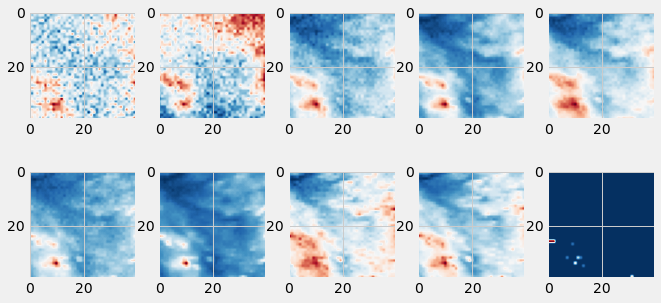

In [0]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 5))

for i in range(9):
    plt.subplot(2,5,i+1)
    plt.imshow(image_sample[:, :, i], cmap=color_map)

plt.subplot(2,5,10)
plt.imshow(image_sample[:,:,-1], cmap = color_map)
plt.show()

In [0]:
image_sample.shape

(40, 40, 15)

## 시각화 하기

In [0]:
image_sample[20,20,10]

157.83774

In [0]:
train_numeric = np.zeros((train.shape[0],4))

In [0]:
train[1,0,0,10]

162.0392

In [0]:
train[1,39,39,10]

163.07806

In [0]:
train_numeric[:,0] = train[:,20,20,9] # land type
train_numeric[:,1] = train[:,20,20,10] # GMI longitude
train_numeric[:,2] = train[:,20,20,11] # GMI latitude
train_numeric[:,3] = np.sum(np.sum(train[:,:,:,14],axis = 1), axis = 1)/1600 #precipitation
train_numeric[train_numeric[:,3]<0,3]= 0## Null값은 모두 0으로 초기화

In [0]:
train_numeric = pd.DataFrame(train_numeric)
train_numeric.columns = ['land_type', 'GMI_longitude', 'GMI_latitude', 'precipitation']

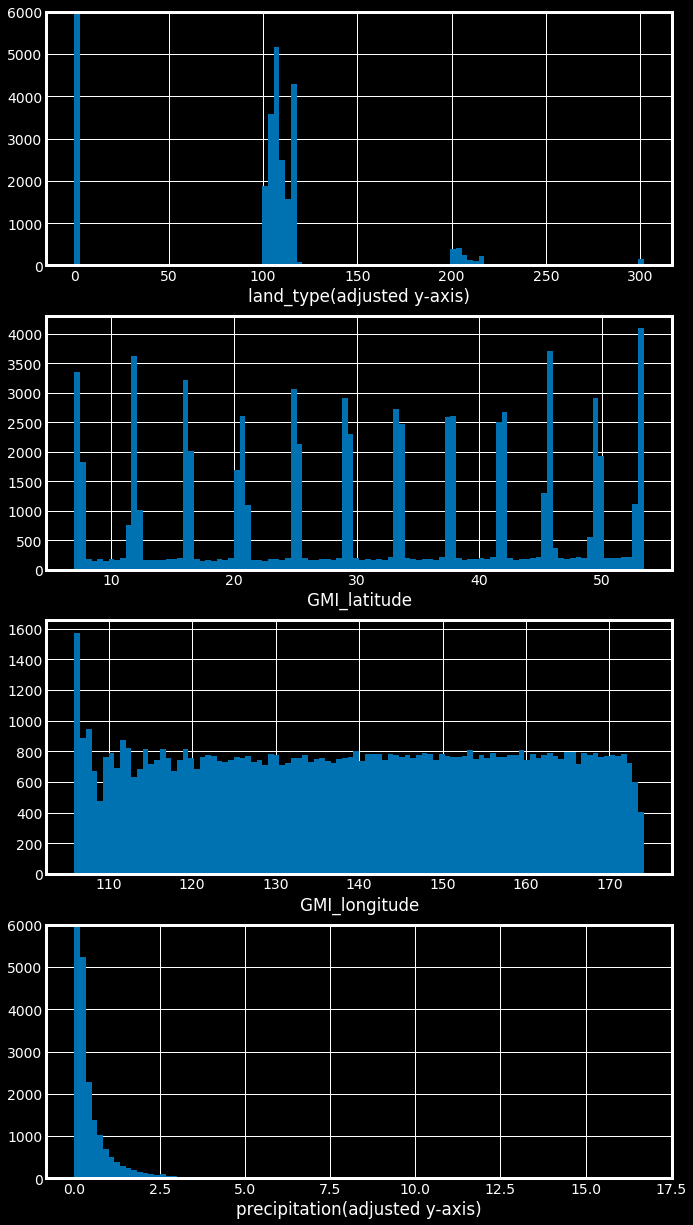

In [0]:
plt.style.use('seaborn-colorblind')
plt.figure(figsize = (10,20))

plt.subplot(4,1,1)
plt.hist(train_numeric.land_type, bins = 100)
plt.ylim(0,6000)
plt.xlabel('land_type(adjusted y-axis)')

plt.subplot(4,1,2)
plt.hist(train_numeric.GMI_latitude, bins = 100)
plt.xlabel('GMI_latitude')

plt.subplot(4,1,3)
plt.hist(train_numeric.GMI_longitude, bins = 100)
plt.xlabel('GMI_longitude')

plt.subplot(4,1,4)
plt.hist(train_numeric.precipitation, bins = 100)
plt.ylim(0,6000)
plt.xlabel('precipitation(adjusted y-axis)')

plt.show()

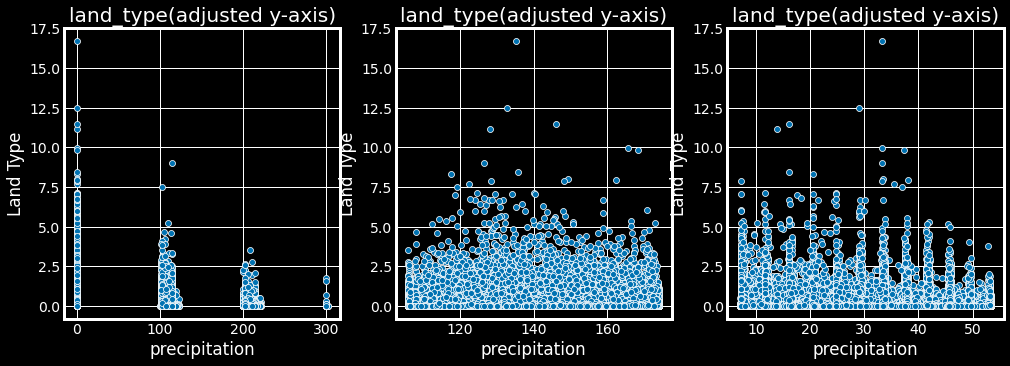

In [0]:
plt.style.use('seaborn-colorblind')
plt.figure(figsize = (15,5))

plt.subplot(1,3,1)
sns.scatterplot(train_numeric.land_type,train_numeric.precipitation)
plt.xlabel('precipitation')
plt.ylabel('Land Type')
plt.title('land_type(adjusted y-axis)')

plt.subplot(1,3,2)
sns.scatterplot(train_numeric.GMI_latitude,train_numeric.precipitation)
plt.xlabel('precipitation')
plt.ylabel('Land Type')
plt.title('land_type(adjusted y-axis)')

plt.subplot(1,3,3)
sns.scatterplot(train_numeric.GMI_longitude,train_numeric.precipitation)
plt.xlabel('precipitation')
plt.ylabel('Land Type')
plt.title('land_type(adjusted y-axis)')

plt.show()

Text(0.5, 1.0, 'Satellite map')

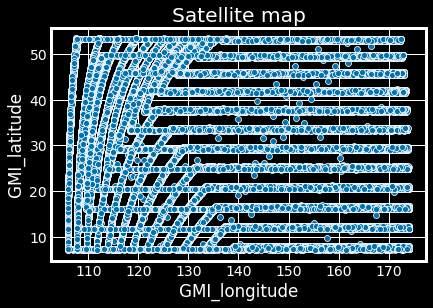

In [0]:
sns.scatterplot(train_numeric.GMI_longitude,train_numeric.GMI_latitude)
plt.xlabel('GMI_longitude')
plt.ylabel('GMI_latitude')
plt.title('Satellite map')

In [0]:
!pip install basemap
!pip install -U git+https://github.com/matplotlib/basemap.git
from mpl_toolkits.basemap import Basemap

  Cloning https://github.com/matplotlib/basemap.git to /tmp/pip-req-build-gtzzdfm2
  Running command git clone -q https://github.com/matplotlib/basemap.git /tmp/pip-req-build-gtzzdfm2
  Created wheel for basemap: filename=basemap-1.2.1-cp36-cp36m-linux_x86_64.whl size=121756030 sha256=552b7459348f8f47a296215b6678c9118f1e8b665e321f05d944988bd371830e
  Stored in directory: /tmp/pip-ephem-wheel-cache-wuexmw3f/wheels/3f/f3/56/de548b66967d0d661612b7618022e2c0d4b86b9a638cf6ccf3
Successfully built basemap
  Found existing installation: basemap 1.1.0
    Uninstalling basemap-1.1.0:
      Successfully uninstalled basemap-1.1.0


In [0]:
from mpl_toolkits.basemap import Basemap

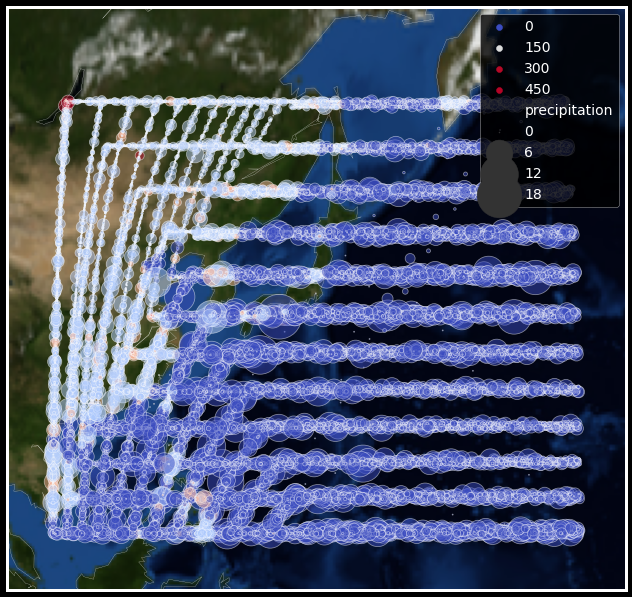

In [0]:
## 전체 데이터 지도위에 그리기
plt.figure(figsize = (10,10))
fig = plt.gcf()

m = Basemap(projection='merc', \
            llcrnrlat=0, urcrnrlat=60, \
            llcrnrlon=100, urcrnrlon=180, \
            lat_ts=20, \
            resolution='c')

m.bluemarble(scale=0.2)   # full scale will be overkill
m.drawcoastlines(color='white', linewidth=0.2)  # add coastlines
x, y = m(train_numeric.GMI_longitude.values, train_numeric.GMI_latitude.values)  # transform coordinates

cmap = 'coolwarm'
ax = sns.scatterplot(x=x, y=y,
                     hue=train_numeric.land_type.values, # 색깔은 Land type
                     palette=cmap,
                     sizes=(1, 2000),
                     size=train_numeric.precipitation, # 크기는 Precipitation
                     alpha = 0.5
                     )
plt.show()


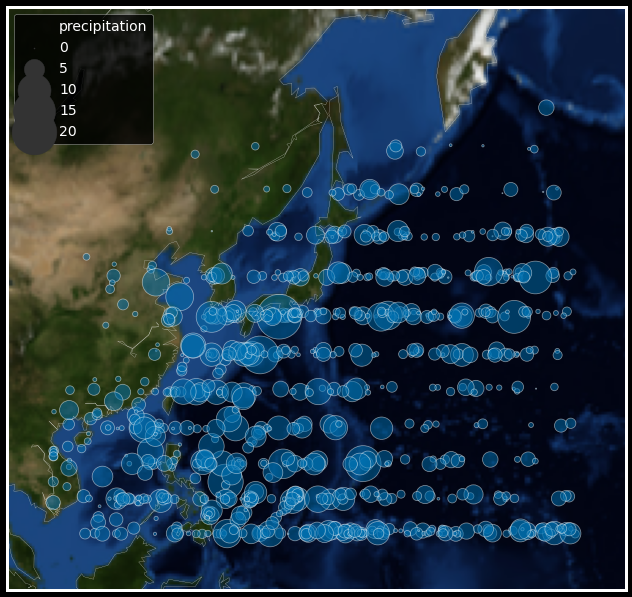

In [0]:
#강수 데이터 지도 위에 그리기
train_numeric_rain = train_numeric[train_numeric['precipitation'] > 2]
gc.collect()

plt.figure(figsize = (10,10))
fig = plt.gcf()

m = Basemap(projection='merc', \
            llcrnrlat=0, urcrnrlat=60, \
            llcrnrlon=100, urcrnrlon=180, \
            lat_ts=20, \
            resolution='c')

m.bluemarble(scale=0.2)   # full scale will be overkill
m.drawcoastlines(color='white', linewidth=0.2)  # add coastlines
x, y = m(train_numeric_rain.GMI_longitude.values, train_numeric_rain.GMI_latitude.values)  # transform coordinates

cmap = 'coolwarm'
ax = sns.scatterplot(x=x, y=y,
                     #hue=train_numeric_rain.land_type.values, # 색깔은 Land type
                     palette=cmap,
                     sizes=(1, 2000),
                     size=train_numeric_rain.precipitation, # 크기는 Precipitation
                     alpha = 0.5
                     )
plt.show()

## 모델만들기

In [0]:
def build_model(input_layer, start_neurons):
    
    # 40 x 40 -> 20 x 20
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(pool1)
    pool1 = Dropout(0.25)(pool1)

    # 20 x 20 -> 10 x 10
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(pool2)
    pool2 = Dropout(0.25)(pool2)

    # 10 x 10 
    convm = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)

    # 10 x 10 -> 20 x 20
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.25)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)

    # 20 x 20 -> 40 x 40
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.25)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Dropout(0.25)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation='relu')(uconv1)
    
    return output_layer

input_layer = Input((40, 40, 10))
output_layer = build_model(input_layer, 32)

In [0]:
model = Model(input_layer, output_layer)

In [0]:
from sklearn.metrics import f1_score

def mae(y_true, y_pred) :
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    over_threshold = y_true >= 0.1
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))

def fscore(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    remove_NAs = y_true >= 0
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0)
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    return(f1_score(y_true, y_pred))

def maeOverFscore(y_true, y_pred):
    return mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)

def fscore_keras(y_true, y_pred):
    score = tf.py_function(func=fscore, inp=[y_true, y_pred], Tout=tf.float32, name='fscore_keras')
    return score

def maeOverFscore_keras(y_true, y_pred):
    score = tf.py_function(func=maeOverFscore, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mse') 
    return score

In [0]:
model.compile(loss="mae", optimizer="adam", metrics=[maeOverFscore_keras, fscore_keras])

## 데이터 제네레이터 만들기

In [0]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
model_history = []
fold_number = 0

for train_index, test_index in kf.split(train):
    print(f'\nFold {fold_number}')
    fold_number = fold_number + 1
    
#-----------------------------------------------------------------------------
    def trainGenerator():
        for file in train[train_index]:
            target= file[:,:,-1].reshape(40,40,1)
            cutoff_labels = np.where(target < 0, 0, target)
            feature = file[:,:,:10]#########################land type 추가
            if (cutoff_labels > 0).sum() < 50:
                continue
            yield (feature, cutoff_labels)
    train_dataset = tf.data.Dataset.from_generator(trainGenerator,
                                                (tf.float32, tf.float32),
                                                (tf.TensorShape([40,40,10]),########################land type 추가
                                                    tf.TensorShape([40,40,1])))
    train_dataset = train_dataset.batch(512).prefetch(1)
#-----------------------------------------------------------------------------
    def testGenerator():
        for file in train[test_index]:
            target= file[:,:,-1].reshape(40,40,1)
            cutoff_labels = np.where(target < 0, 0, target)
            feature = file[:,:,:10]#########################land type 추가
            if (cutoff_labels > 0).sum() < 50:
                continue
            yield (feature, cutoff_labels)
    test_dataset = tf.data.Dataset.from_generator(testGenerator,
                                                (tf.float32, tf.float32),
                                                (tf.TensorShape([40,40,10]),########################land type 추가
                                                    tf.TensorShape([40,40,1])))
    test_size = len(test_index)
    test_dataset = test_dataset.batch(test_size).prefetch(1)
#-----------------------------------------------------------------------------

    
    
    history = model.fit(train_dataset, epochs = 10, verbose=1, validation_data = test_dataset)

    #history = model.fit(train_dataset, epochs = 5, ,batch_size = 11, verbose=1)
    model_history.append(history)
    #del data
    del train_dataset
    del test_dataset
    gc.collect()


Fold 0
Epoch 1/10
44/44 [==============================] - 42s 945ms/step - loss: 0.4592 - maeOverFscore_keras: 6.3886 - fscore_keras: 0.3527 - val_loss: 0.2905 - val_maeOverFscore_keras: 4.0041 - val_fscore_keras: 0.4712
Epoch 2/10
44/44 [==============================] - 38s 853ms/step - loss: 0.3020 - maeOverFscore_keras: 3.2665 - fscore_keras: 0.5533 - val_loss: 0.2853 - val_maeOverFscore_keras: 3.6380 - val_fscore_keras: 0.5103
Epoch 3/10
44/44 [==============================] - 37s 850ms/step - loss: 0.2880 - maeOverFscore_keras: 3.0440 - fscore_keras: 0.5790 - val_loss: 0.2814 - val_maeOverFscore_keras: 3.3206 - val_fscore_keras: 0.5494
Epoch 4/10
44/44 [==============================] - 37s 843ms/step - loss: 0.2773 - maeOverFscore_keras: 2.7557 - fscore_keras: 0.6168 - val_loss: 0.3065 - val_maeOverFscore_keras: 4.5501 - val_fscore_keras: 0.4434
Epoch 5/10
44/44 [==============================] - 37s 848ms/step - loss: 0.2692 - maeOverFscore_keras: 2.5503 - fscore_keras: 0.64

In [0]:
## 모델 저장하기
model.save('model_landtype.h5')
!cp model_landtype.h5 '/content/drive/My Drive/2020 Kaggle Study/model'

In [0]:
def plot_acc(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['maeOverFscore_keras'], label='maeOverFscore_keras')
    plt.plot(np.arange(0, epoch), his.history['val_maeOverFscore_keras'], label='val_maeOverFscore_keras')
    plt.title(title)
    plt.xlabel(f'Epoch {epoch}')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    plt.show()

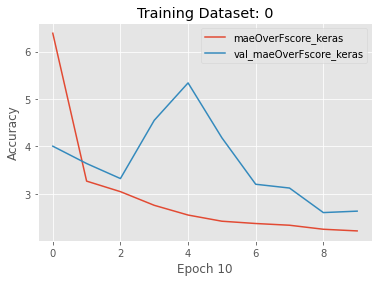

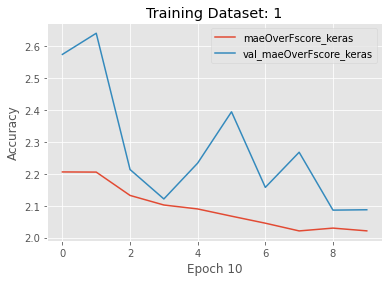

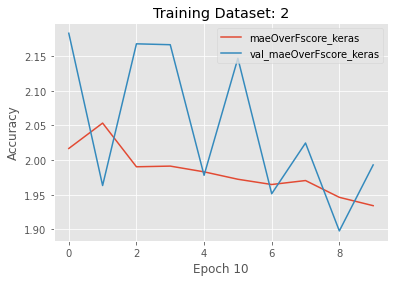

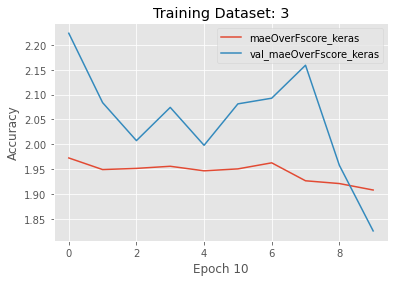

In [0]:
for dataset in range(4):
    #plot_loss(model_history[dataset], 10 , f'Training Dataset: {dataset}')
    plot_acc(model_history[dataset], 10 , f'Training Dataset: {dataset}')


## submission 만들기

In [0]:
# 훈련에서 사용하는 0~8번 채널, ladtype 만을 뽑아서 X_test에 저장하기
test_submit = np.load('/content/drive/My Drive/2020 Kaggle Study/data/test.npy')
test_submit = test_submit[:,:,:,:10]
del test_submit
gc.collect()
pred = model.predict(test_submit)

## submission 만들기

In [0]:
submission = pd.read_csv('/content/drive/My Drive/2020 Kaggle Study/data/sample_submission.csv')

In [0]:
submission.iloc[:,1:] = pred.reshape(-1, 1600)

In [0]:
submission.to_csv('Dacon_landtype.csv', index = False)

In [0]:
# 제출파일 구글 드라이브에 올리기
!cp Dacon_landtype.csv '/content/drive/My Drive/2020 Kaggle Study/submission'